# Modeling with Neural Networks
## -- work in process

In [ ]:
#imports
%load_ext autoreload
%autoreload 2

In [7]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import cleaning_functions as cfs
from src import preprocessing_functions as pfs
from src import modeling_functions as mfs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import recall_score, f1_score, make_scorer
import xgboost 
import tensorflow as tf

In [34]:
df = cfs.cleaned_dataframe()

In [35]:
df = df.drop(['vdcmun_id', 'ward_id'], axis=1)

In [36]:
#create target and feature dataframes 
y = df['target']
X = df.drop('target', axis=1)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2015, test_size = .2)

#train validation split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state = 2015, test_size = .25)

#stratified sampling to have equal representation of classes
rus = RandomUnderSampler(random_state=2015)
X_tr_res, y_tr_res = rus.fit_resample(X_tr, y_tr)

#One Hot encode all categorical features land_surface_condition,foundation_type, roof_type, ground_floor_type, other_floor_type
X_tr_res, X_val, X_test = pfs.ohe_train_and_test_features(X_tr_res, X_val, X_test)

#One hot encode district_id
X_tr_res, X_val, X_test = pfs.ohe_train_val_test_geos(X_tr_res, X_val, X_test)

In [37]:
X_train_scaled = X_tr_res.copy()
col_names = ['count_floors_pre_eq', 'count_families', 'age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq']
features = X_train_scaled[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

X_train_scaled[col_names] = features
X_train_scaled.head()

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,20,21,22,23,24,28,29,30,31,36
0,-1.536583,0.442693,-1.098342,-1.386090,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.536583,-0.120057,-0.952638,-1.386090,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.047621,-0.241732,-0.118883,-0.686274,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.047621,-0.089638,0.302041,-0.686274,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.047621,0.016828,-0.471003,0.363450,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [38]:
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

features = X_val_scaled[col_names]
features = scaler.transform(features.values)
X_val_scaled[col_names] = features
features = X_test_scaled[col_names]
features = scaler.transform(features.values)
X_test_scaled[col_names] = features

In [39]:
ohe = OneHotEncoder(sparse=False)
y_train_nn = ohe.fit_transform(y_tr_res.values.reshape(-1,1))
y_val_nn = ohe.transform(y_val.values.reshape(-1,1))
y_test_nn = ohe.transform(y_test.values.reshape(-1,1))

In [72]:
np.random.seed(2015)
tf.random.set_seed(2015)

model1 = Sequential()
model1.add(Dense(32, activation='relu', input_dim=76,))
model1.add(Dense(8 ,  activation='relu' ))
model1.add(Dense(3 , activation = 'softmax' ))

model1.compile(optimizer='adam',
              loss='categorical_crossentropy'  ,
              metrics=['accuracy'])
results = model1.fit(X_train_scaled.values, y_train_nn, epochs=20, batch_size= 100, validation_data=(X_val_scaled.values, y_val_nn))

Train on 245571 samples, validate on 152419 samples
Epoch 1/20
245571/245571 [==============================] - 11s 44us/sample - loss: 0.8583 - accuracy: 0.5907 - val_loss: 0.8431 - val_accuracy: 0.6033
Epoch 2/20
245571/245571 [==============================] - 11s 47us/sample - loss: 0.8345 - accuracy: 0.6049 - val_loss: 0.8237 - val_accuracy: 0.5964
Epoch 3/20
245571/245571 [==============================] - 13s 54us/sample - loss: 0.8288 - accuracy: 0.6076 - val_loss: 0.7881 - val_accuracy: 0.6328
Epoch 4/20
245571/245571 [==============================] - 14s 57us/sample - loss: 0.8249 - accuracy: 0.6107 - val_loss: 0.7854 - val_accuracy: 0.6312
Epoch 5/20
245571/245571 [==============================] - 14s 57us/sample - loss: 0.8226 - accuracy: 0.6125 - val_loss: 0.8216 - val_accuracy: 0.6107
Epoch 6/20
245571/245571 [==============================] - 14s 59us/sample - loss: 0.8205 - accuracy: 0.6139 - val_loss: 0.8249 - val_accuracy: 0.6017
Epoch 7/20
245571/245571 [==========

In [73]:
results.history

{'loss': [0.8582545921363209,
  0.8345174629894642,
  0.828752585900476,
  0.8249397317727685,
  0.822588263130275,
  0.8205306883525675,
  0.8194036721927402,
  0.8182219665957235,
  0.8170335168245705,
  0.8162432471154801,
  0.8154627535545413,
  0.8146529094302037,
  0.8140744023827312,
  0.8133120321022526,
  0.8128731433066438,
  0.8123579307030847,
  0.8119001811389845,
  0.8114437192222019,
  0.8110997486519163,
  0.8107385257247126],
 'accuracy': [0.5907049,
  0.60489225,
  0.6075595,
  0.6107317,
  0.61245424,
  0.6139406,
  0.6140505,
  0.61460435,
  0.6155083,
  0.616168,
  0.6166689,
  0.6172716,
  0.6174711,
  0.61794347,
  0.6180494,
  0.6184851,
  0.61855024,
  0.6198615,
  0.6198248,
  0.62020355],
 'val_loss': [0.8430862195427548,
  0.8236608305426288,
  0.7881091000970917,
  0.7853750717952065,
  0.8215694799562215,
  0.8248643427994359,
  0.7906858716989223,
  0.7782662564790942,
  0.7768068724033388,
  0.808522051181781,
  0.8027537350644622,
  0.7848912213795164,


In [74]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_mse = history['accuracy']
val_mse = history['val_accuracy']

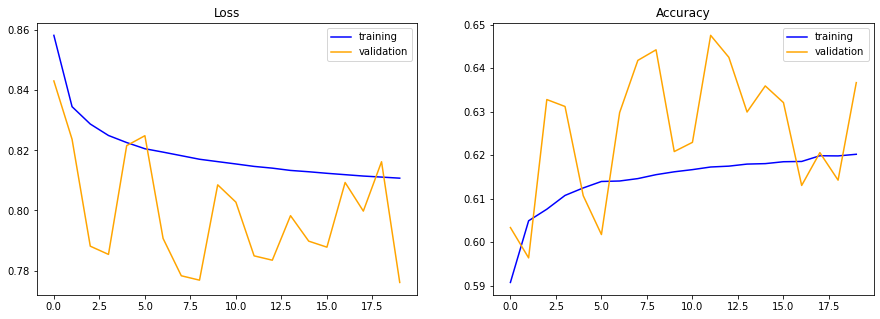

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(list(range(len(training_loss))), training_loss, c='b', label='training', ax=ax1)
sns.lineplot(list(range(len(val_loss))), val_loss, c='orange', label='validation', ax=ax1)
sns.lineplot(list(range(len(training_loss))), training_mse, c='b', label='training',ax=ax2)
sns.lineplot(list(range(len(val_loss))), val_mse, c='orange', label='validation',ax=ax2)
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [76]:
val_preds = model1.predict_classes(X_val_scaled.values)

In [77]:
val_preds_ref = val_preds + 1

In [78]:
val_preds_ref

array([2, 2, 3, ..., 2, 1, 3])

In [79]:
y_val.values

array([1., 3., 3., ..., 3., 2., 3.])

In [80]:
from sklearn.metrics import classification_report
confusion_matrix(y_val.values, val_preds_ref)

array([[22640,  7569,  2909],
       [ 6387, 13712,  7310],
       [ 6308, 24892, 60692]])

In [81]:
print(classification_report(y_val.values, val_preds_ref))

              precision    recall  f1-score   support

         1.0       0.64      0.68      0.66     33118
         2.0       0.30      0.50      0.37     27409
         3.0       0.86      0.66      0.75     91892

    accuracy                           0.64    152419
   macro avg       0.60      0.61      0.59    152419
weighted avg       0.71      0.64      0.66    152419



In [84]:
np.random.seed(2015)
tf.random.set_seed(2015)

model2 = Sequential()
model2.add(Dense(32, activation='relu', input_dim=76, kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(16 ,  activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(16 ,  activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(3 , activation = 'softmax' ))

model2.compile(optimizer='adam',
              loss='categorical_crossentropy'  ,
              metrics=['accuracy'])
results = model2.fit(X_train_scaled.values, y_train_nn, epochs=30, batch_size= 100, validation_data=(X_val_scaled.values, y_val_nn))

Train on 245571 samples, validate on 152419 samples
Epoch 1/30
245571/245571 [==============================] - 12s 49us/sample - loss: 0.9922 - accuracy: 0.5807 - val_loss: 0.9022 - val_accuracy: 0.6200
Epoch 2/30
245571/245571 [==============================] - 13s 54us/sample - loss: 0.9133 - accuracy: 0.5871 - val_loss: 0.9069 - val_accuracy: 0.5905
Epoch 3/30
245571/245571 [==============================] - 15s 61us/sample - loss: 0.9041 - accuracy: 0.5871 - val_loss: 0.8625 - val_accuracy: 0.6299
Epoch 4/30
245571/245571 [==============================] - 16s 64us/sample - loss: 0.8988 - accuracy: 0.5894 - val_loss: 0.8688 - val_accuracy: 0.6177
Epoch 5/30
245571/245571 [==============================] - 16s 67us/sample - loss: 0.8955 - accuracy: 0.5900 - val_loss: 0.8450 - val_accuracy: 0.6356
Epoch 6/30
245571/245571 [==============================] - 17s 68us/sample - loss: 0.8930 - accuracy: 0.5917 - val_loss: 0.9114 - val_accuracy: 0.5708
Epoch 7/30
245571/245571 [==========

In [85]:
val_preds2 = model2.predict_classes(X_val_scaled.values)
val_preds2[:10]

array([1, 1, 2, 2, 1, 2, 1, 2, 1, 2])

In [86]:
model2.predict(X_val_scaled.values)

array([[0.17144905, 0.44372493, 0.38482606],
       [0.15585847, 0.42436627, 0.41977528],
       [0.05263007, 0.2254328 , 0.7219372 ],
       ...,
       [0.26853344, 0.46452168, 0.2669449 ],
       [0.8938804 , 0.09785055, 0.00826907],
       [0.16852178, 0.44025883, 0.3912194 ]], dtype=float32)

In [87]:
val_preds2_ref = val_preds2 + 1

In [88]:
print(classification_report(y_val.values, val_preds2_ref))

              precision    recall  f1-score   support

         1.0       0.65      0.65      0.65     33118
         2.0       0.28      0.46      0.35     27409
         3.0       0.84      0.67      0.75     91892

    accuracy                           0.63    152419
   macro avg       0.59      0.60      0.58    152419
weighted avg       0.70      0.63      0.65    152419

